# Logistic regression example

Here we fit a logistic regression model.
First we generate $N=100$ observations from
a Benoulli$(p_n)$ distribution,
where $p_n=\mathrm{logit}(\beta_0+\beta_1 x_n)$
and $X_n\sim\mathcal{N}(-1,1.5^2)$.
We take $\beta=(2,3)$ and assume that $\beta_0$ is known.
We approximate the posterior distribution three different ways:

1. running 10,000 iterations of HMC using Stan 
(and discarding the first 5,000 as burn-in);
2. minimizing the reverse KL from the family of Gaussians
to the posterior;
3. ditto, but the forward KL from the posterior to the family of Gaussians.

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import vi
import pystan

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 32})
figpath='../doc/fig/'

## Data generation

We generate the observations and the regressors,
with a seed for reproducibility.

We also estimate the normalizing constant of the posterior
and plot the posterior density to verify that it is
symmetric and unimodal 
(and therefore might be well-approximated by a Gaussian).

In [2]:
############################
############################
##    data generation     ##
############################
############################

# settings
np.random.seed(520)
N = 100 
true_beta = np.array([2.,3.])

# create data matrix
X = np.ones((N,2))
X[:,1] = -1.+1.5*np.random.randn(N)

# create response variable
eta = X.dot(true_beta)
true_p = 1./(1+np.exp(-eta))
Y = np.random.binomial(1,true_p,N)

### Posterior plot

In [4]:
# gaussian log density
def gauss_lp(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*logsigma-0.5*np.log(2*np.pi)

In [5]:
############################
############################
## posterior distribution ##
############################
############################
#altY=np.maximum(1e-5,np.minimum(1-1e-5,Y))[:,np.newaxis] # to be able to take logarithms
prbs = lambda beta : 1./(1.+np.exp(-true_beta[0]-beta[:,np.newaxis]*X[:,1]))
ll = lambda beta : np.sum(Y*np.log(prbs(beta))+(1-Y)*np.log(1-prbs(beta)),axis=1)
lprior = lambda beta : gauss_lp(beta,0.,np.log(30.))
lp = lambda beta : ll(beta)+lprior(beta) # target p(x,z)

In [6]:
low,high=-5,10
lsx=np.linspace(low,high,10000)
# estimate normalizing constant
target=np.exp(lp(lsx))
Z=np.sum(target)*(high-low)/lsx.shape[0]
print('Normalizing constant estimate: '+str(Z))

Normalizing constant estimate: 1.8945235584498607e-15


Text(0, 0.5, 'Density')

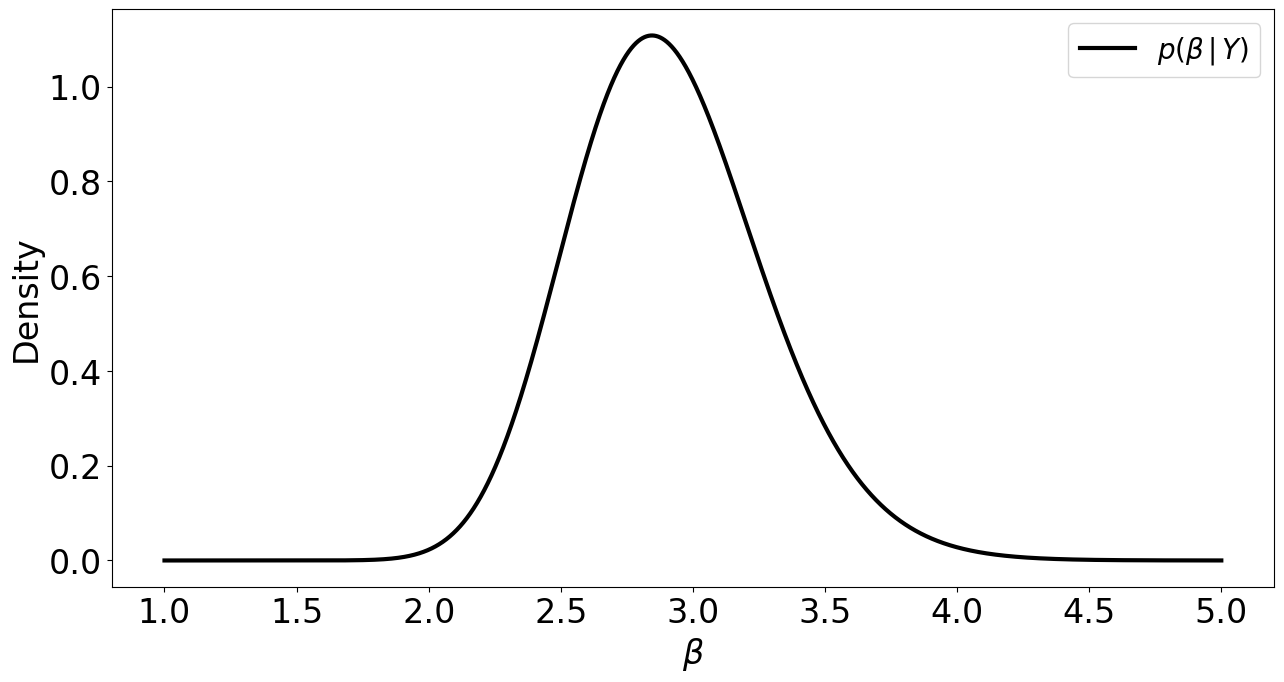

In [7]:
ls=np.linspace(1,5,10000)
target=np.exp(lp(ls))
plt.plot(ls,target/Z,color='black',lw=3,label=r'$p(\beta\,|\,Y)$')
plt.legend(fontsize='small')
plt.xlabel(r'$\beta$')
plt.ylabel('Density')

## Run MCMC with Stan

We define the model in Stan and run 10,000 of Hamiltonian Monte Carlo
to explore the posterior distribution of $\beta_1$.

We show some summary statistics, a posterior histogram,
and a traceplot to verify that the chain converged to the posterior.

In [8]:
# model definition
stan_code = """
data {
  int<lower=0> n; // number of observations
  int y[n]; // responses
  vector[n] x1; // predictors
  real beta0; // intercept
}
parameters {
  real beta1;
}
model {
  beta1 ~ normal(0, 30);
  y ~ bernoulli_logit(beta0+beta1*x1);
}
"""

In [173]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_885816be3a6e229f8e2d0b5893720007 NOW.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/2

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:3

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:846:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long lo

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:336:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/prob/poisson_log_glm_log.hpp:5:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/prob/poisson_log_glm_lpmf.hpp:64:59: warning: unused typedef 'T_alpha_val' [-Wunused-local-typedef]
      typename partials_return_type<T_alpha>::type>::type T_alpha_val;
                

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:3

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:846:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long lo

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_s22cpjdm/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_6209305726933947658.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

163 warnings generated.
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'


In [174]:
# run in stan
stan_data = {'n': N,
             'y': Y,
             'x1': X[:,1],
             'beta0': true_beta[0]}
fit = model.sampling(data=stan_data, iter=10000, chains=1)


Gradient evaluation took 0.000192 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.92 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.215086 seconds (Warm-up)
               0.261889 seconds (Sampling)
               0.476975 seconds (Total)



In [175]:
# summary statistics
print(fit.stansummary(pars=['beta1']))
samples = fit.extract()

Inference for Stan model: anon_model_885816be3a6e229f8e2d0b5893720007.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   2.91  9.9e-3   0.37   2.25   2.66   2.89   3.15   3.73   1424    1.0

Samples were drawn using NUTS at Tue Apr 25 11:03:19 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


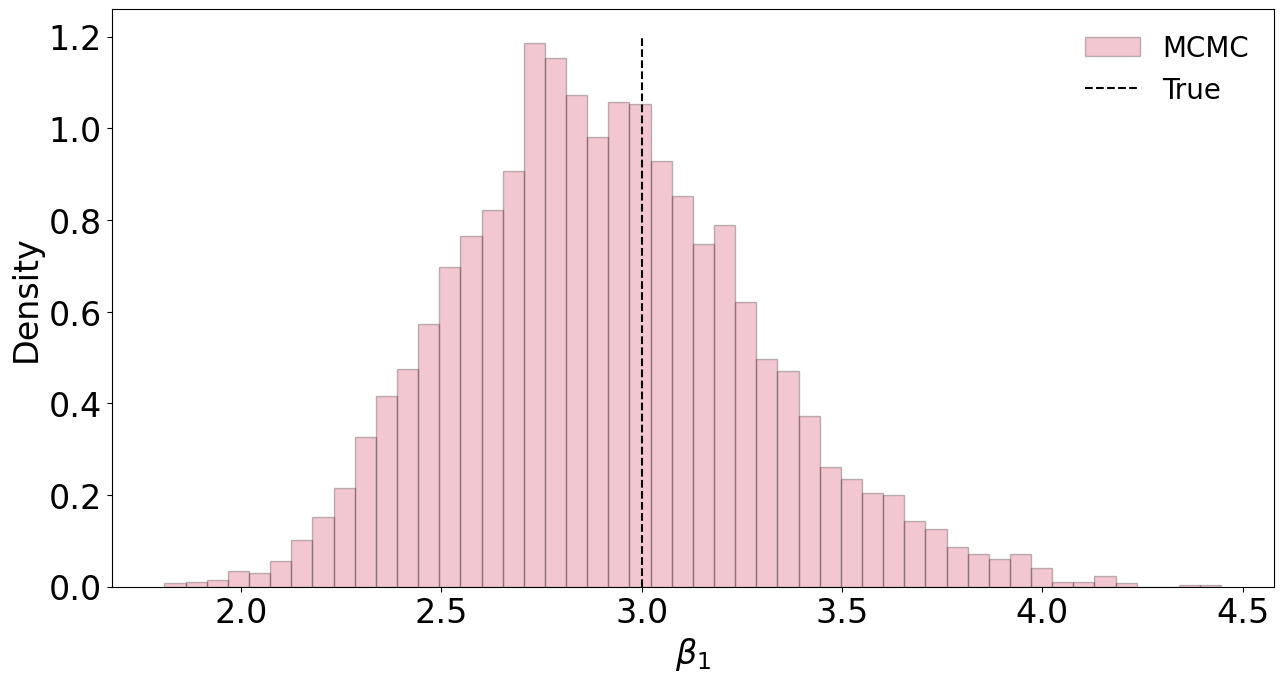

In [176]:
plt.hist(samples['beta1'], color='#D3214BFF',ec='black',alpha=0.25,label='MCMC',density=True,bins=50)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label='True')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
#for lh in leg.legendHandles: lh.set_alpha(1)
#plt.savefig(fig_path+'logreg_mcmc_scatter.pdf', dpi=300, bbox_inches='tight')

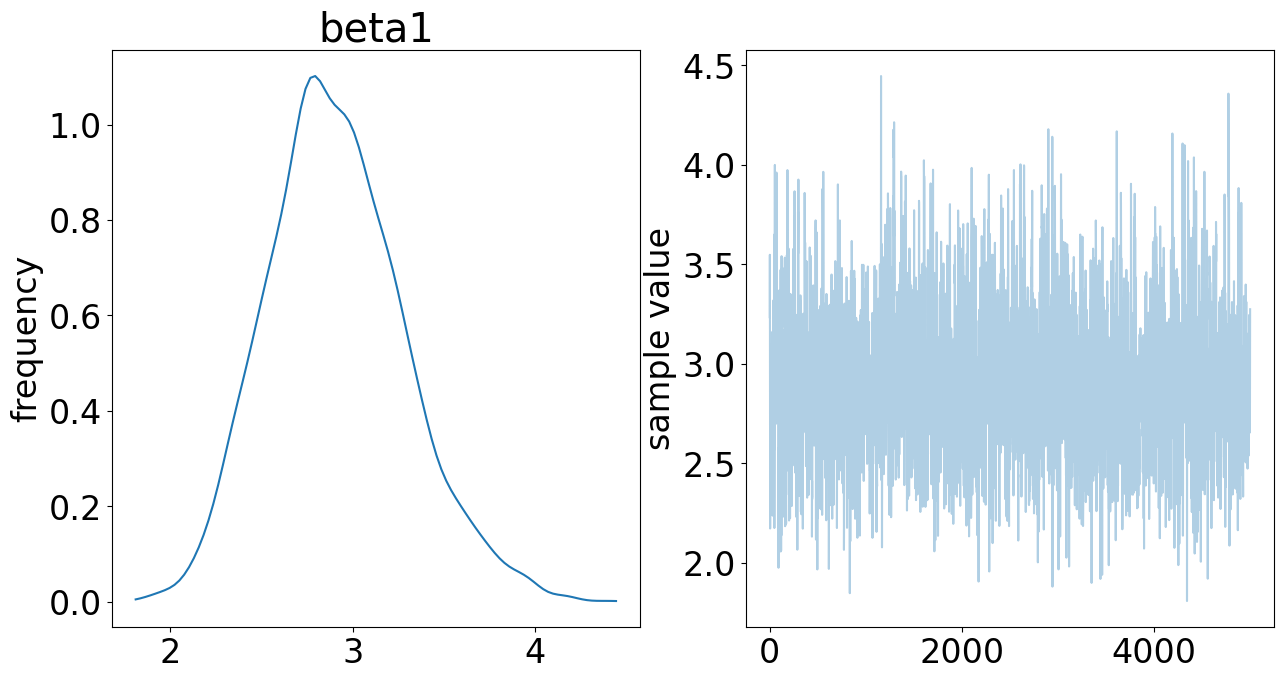

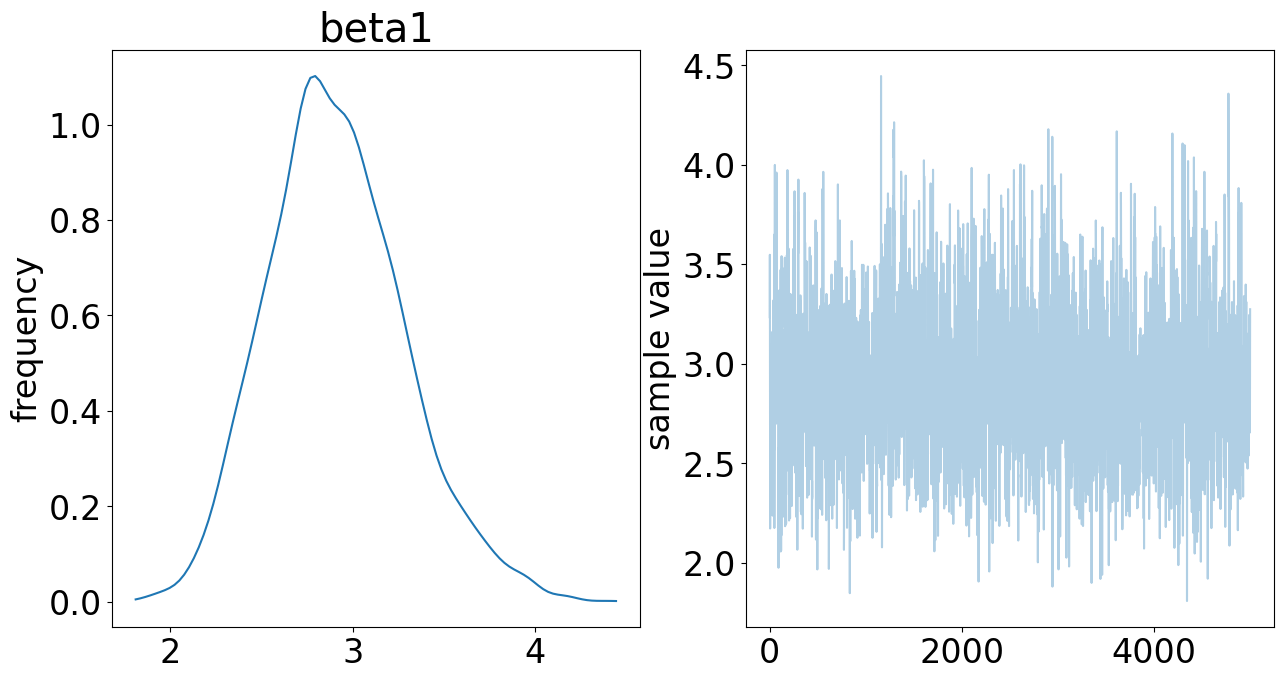

In [177]:
fit.plot()

## Fit variational approximations

Now we minimize the reverse and forward KL divergences
to find two variational approximations.
For the forward KL,
we use the Stan samples as samples from the posterior.

In [14]:
# gaussian variational approximation
def lq(x,mu,logsigma):
    sigma=np.exp(logsigma)
    return -0.5*((x-mu)/sigma)**2-0.5*np.log(2*np.pi*sigma**2)

In [15]:
##########################
##########################
#    posterior defn     #
##########################
##########################
samples_beta1=samples['beta1']
def randp(size): return samples_beta1[:size] # just return the first size Stan samples

### Optimization

In [58]:
##########################
##########################
#    reverse KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=1001
B=1000 # monte carlo sample size for gradient estimation
lr_mu=1e-2
lr_lsigma=5*1e-2
divergence='rev-kl'

rev_mus,rev_lsigmas=vi.gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.2510030901622524   | 1.7646326559470649   | -115.99419582727853  | -16.965288542754436
  100   | 2.7352284427305076   | 0.17144908099813375   | -6.806249225668134  | 1.4985540643059512
  200   | 2.7639263284408173   | 0.21574939456020376   | -0.2928318751209313  | 0.5445418603710672
  300   | 2.7902332264480174   | 0.23814809683174737   | -0.5709407607110506  | -0.07856252554463344
  400   | 2.806651733611768   | 0.25629781161190096   | -2.6778068701482476  | -1.1900353960151613
  500   | 2.8369322863282056   | 0.2849705138708646   | 1.8662602011450722  | -0.4761353936851224
  600   | 2.850899272164129   | 0.3088647052965438   | -2.556846743361567  | -0.41286717557076885
  700   | 2.8632769879533995   | 0.32859307157623   | -4.930892781511368  | -1.081548101778971
  800   | 2.854089861611349   | 0.33021199237811216   | -0.154

In [59]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

rev_mu=rev_mus[-1]
rev_lsigma=rev_lsigmas[-1]

rev_lq = lambda x : vi.lq(x,rev_mu,rev_lsigma)
rev_randq = lambda B : rev_mu+np.exp(rev_lsigma)*np.random.randn(B)

In [51]:
##########################
##########################
#    forward KL opt      #
##########################
##########################

# optimization settings
np.random.seed(520)
max_iters=50001
B=5000 # monte carlo sample size for gradient estimation
lr_mu=1e-1
lr_lsigma=5*1e-2
divergence='fwd-kl'

fwd_mus,fwd_lsigmas=vi.gaussianVI(lp,randp,divergence,B,max_iters,lr_mu,lr_lsigma)

Initial μ: -1.4109450484350377
Initial σ: 0.7555405048862535

Iter  |          μ          |          σ          |      μ gradient     |   logσ gradient
  0   | -0.656510645833076   | 3.688849970860647   | -7.544344026019616  | -31.71273267637453
  5000   | 2.895679268591799   | 0.3671947161659404   | -1.6034809448228772e-09  | 0.059865615488587424
  10000   | 2.8956792688057282   | 0.35608125652591693   | -1.7307115740550217e-13  | 0.00018133098731186337
  15000   | 2.8956792688057282   | 0.3560493625810235   | -1.730938947730465e-13  | 2.0211553222779345e-06
  20000   | 2.8956792688057282   | 0.3560490111774375   | -1.730938947730465e-13  | 4.5634696108720617e-08
  25000   | 2.8956792688057282   | 0.3560490033469189   | -1.7311094779870472e-13  | 1.6178302018943214e-09
  30000   | 2.8956792688057282   | 0.3560490030731473   | -1.7311094779870472e-13  | 7.902150400695973e-11
  35000   | 2.8956792688057282   | 0.3560490030599651   | -1.7312231648247688e-13  | 4.931401065277896e-12
  400

In [60]:
# save optimal mean, lsigma values
# and define log pdf and sampler wrappers

fwd_mu=fwd_mus[-1]
fwd_lsigma=fwd_lsigmas[-1]

fwd_lq = lambda x : vi.lq(x,fwd_mu,fwd_lsigma)
fwd_randq = lambda B : fwd_mu+np.exp(fwd_lsigma)*np.random.randn(B)

## Diagnostics

We show density and log density plots,
along with credible interval limits and coverage.

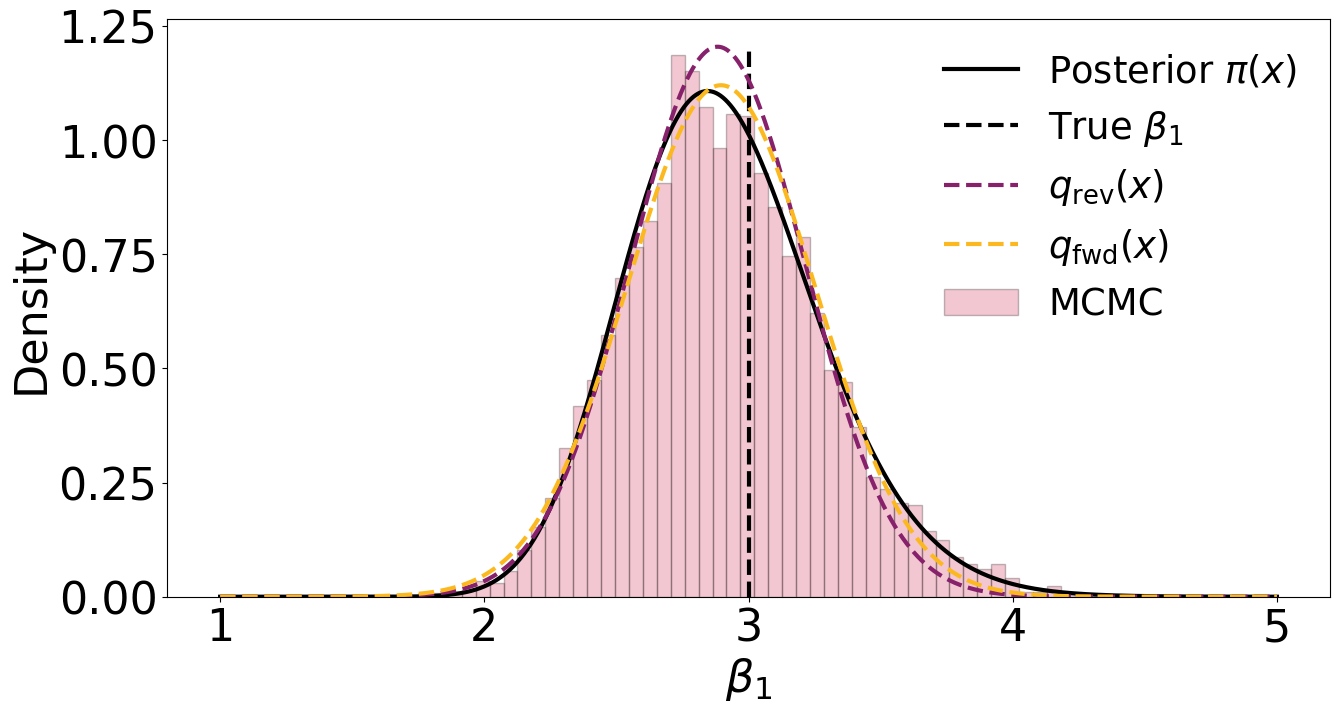

In [197]:
lsx=np.linspace(1,5,10000)
target=np.exp(lp(lsx))/Z
plt.plot(lsx,target,c="black", label=r'Posterior $\pi(x)$',lw=3)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label=r'True $\beta_1$',lw=3)
plt.plot(lsx,np.exp(rev_lq(lsx)),c='#87216BFF', label=r'$q_{\mathrm{rev}}(x)$',lw=3,ls='dashed')
plt.plot(lsx,np.exp(fwd_lq(lsx)),c='#FBB91FFF', label=r'$q_{\mathrm{fwd}}(x)$',lw=3,ls='dashed')
plt.hist(samples['beta1'], color='#D3214BFF',ec='black',alpha=0.25,label='MCMC',density=True,bins=50)
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
plt.savefig(figpath + 'logreg_q.pdf', dpi=300, bbox_inches='tight')

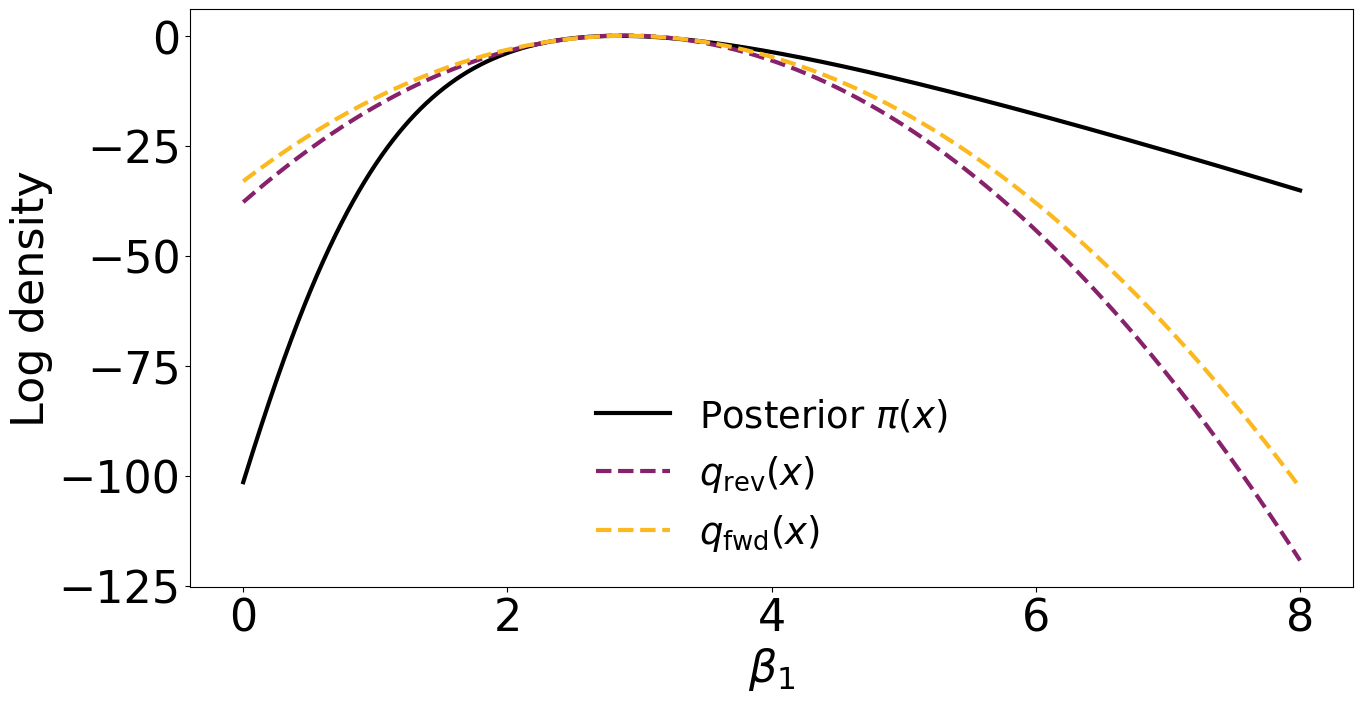

In [198]:
lsx=np.linspace(0,8,10000)
ltarget=lp(lsx)-np.log(Z)
plt.plot(lsx,ltarget,c="black", label=r'Posterior $\pi(x)$',lw=3)
plt.plot(lsx,rev_lq(lsx),c='#87216BFF', label=r'$q_{\mathrm{rev}}(x)$',lw=3,ls='dashed')
plt.plot(lsx,fwd_lq(lsx),c='#FBB91FFF', label=r'$q_{\mathrm{fwd}}(x)$',lw=3,ls='dashed')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Log density')
leg = plt.legend(fontsize='small',frameon=False)
plt.savefig(figpath + 'logreg_logq.pdf', dpi=300, bbox_inches='tight')

In [199]:
alphas=np.flip(np.linspace(0.01,0.2,101)[1:])

lsx=np.linspace(0,8,10000)
target=np.exp(lp(lsx))
# define empirical target distribution based on evaluations
target_empirical=stats.rv_discrete(values=(lsx,target/np.sum(target)))
true_lims_low=target_empirical.ppf(alphas/2)
true_lims_high=target_empirical.ppf(1-alphas/2)

# define empirical MCMC distribution based on samples
mcmc_empirical=stats.rv_discrete(values=(samples_beta1,np.ones(samples_beta1.shape[0])/samples_beta1.shape[0]))
mcmc_lims_low=mcmc_empirical.ppf(alphas/2)
mcmc_lims_high=mcmc_empirical.ppf(1-alphas/2)

rev_lims_low=stats.norm.ppf(alphas/2,loc=rev_mu,scale=np.exp(rev_lsigma))
rev_lims_high=stats.norm.ppf(1-alphas/2,loc=rev_mu,scale=np.exp(rev_lsigma))

fwd_lims_low=stats.norm.ppf(alphas/2,loc=fwd_mu,scale=np.exp(fwd_lsigma))
fwd_lims_high=stats.norm.ppf(1-alphas/2,loc=fwd_mu,scale=np.exp(fwd_lsigma))

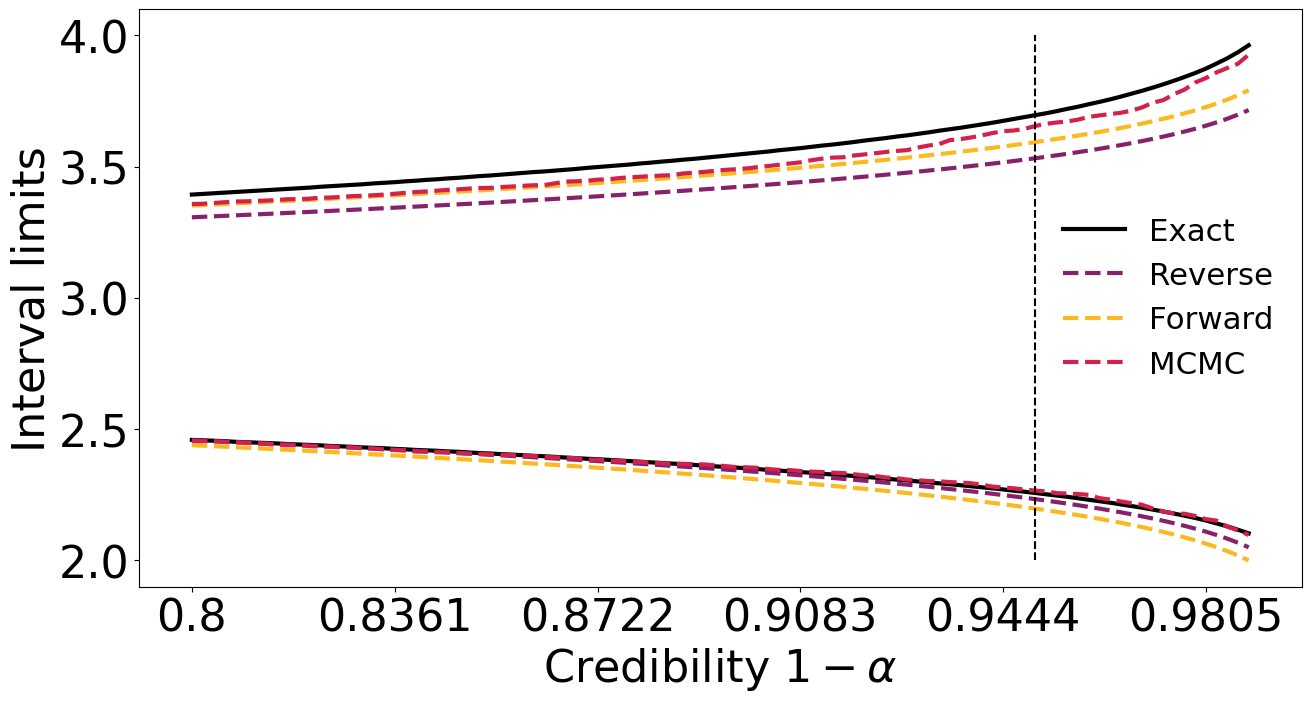

In [204]:
lsa=np.arange(0,alphas.shape[0])

plt.plot(lsa,true_lims_low,label='Exact',c='black',lw=3)
plt.plot(lsa,true_lims_high,label='',c='black',lw=3)
plt.plot(lsa,rev_lims_low,label='Reverse',c='#87216BFF',lw=3,ls='dashed')
plt.plot(lsa,rev_lims_high,label='',c='#87216BFF',lw=3,ls='dashed')
plt.plot(lsa,fwd_lims_low,label='Forward',c='#FBB91FFF',lw=3,ls='dashed')
plt.plot(lsa,fwd_lims_high,label='',c='#FBB91FFF',lw=3,ls='dashed')
plt.plot(lsa,mcmc_lims_low,label='MCMC',c='#D3214BFF',lw=3,ls='dashed')
plt.plot(lsa,mcmc_lims_high,label='',c='#D3214BFF',lw=3,ls='dashed')
plt.vlines(np.argmax(alphas==0.0499),2,4,ls='dashed',color='black')

plt.ylabel('Interval limits')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='x-small',frameon=False,loc='center right');
plt.savefig(figpath + 'logreg_cilims.pdf', dpi=300, bbox_inches='tight')

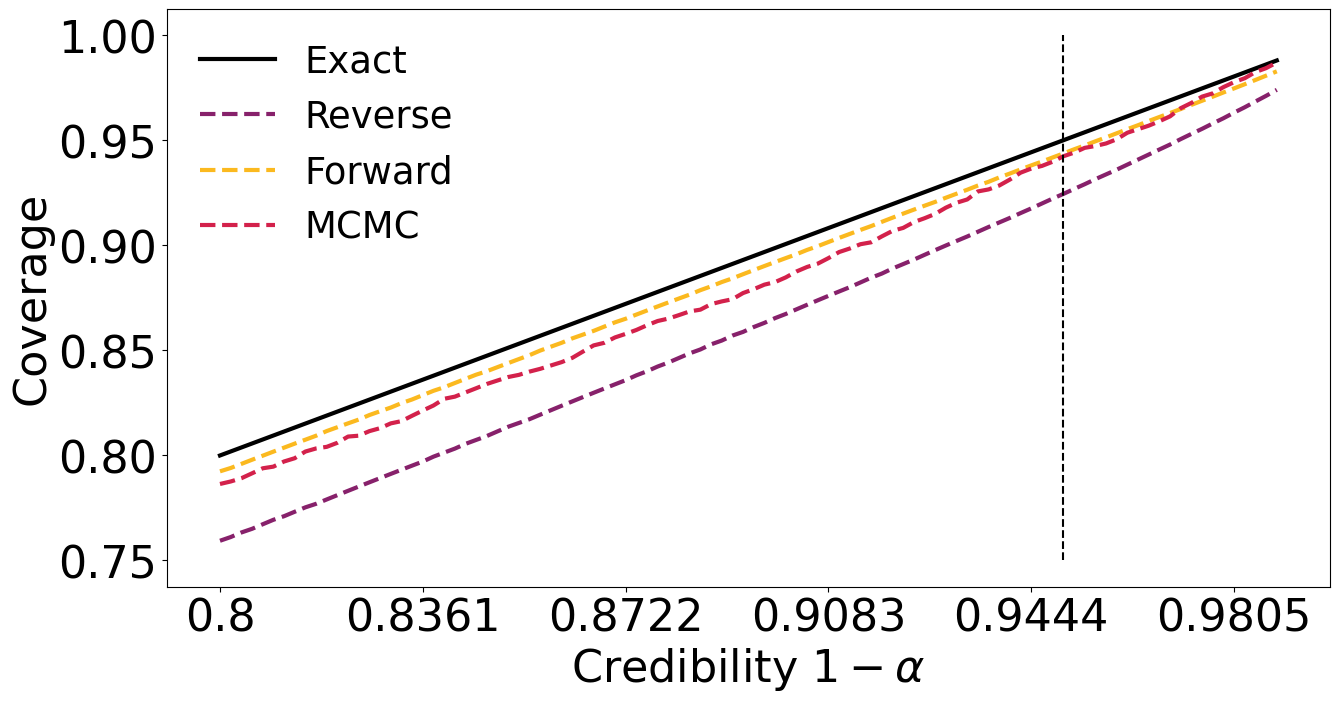

In [205]:
plt.plot(lsa,1-alphas[lsa],label='Exact',lw=3,color='black')
plt.plot(lsa,1-target_empirical.cdf(rev_lims_low)-target_empirical.sf(rev_lims_high),
         label='Reverse',lw=3,color='#87216BFF',ls='dashed')
plt.plot(lsa,1-target_empirical.cdf(fwd_lims_low)-target_empirical.sf(fwd_lims_high),
         label='Forward',lw=3,color='#FBB91FFF',ls='dashed')
plt.plot(lsa,1-target_empirical.cdf(mcmc_lims_low)-target_empirical.sf(mcmc_lims_high),
         label='MCMC',lw=3,color='#D3214BFF',ls='dashed')
plt.vlines(np.argmax(alphas==0.0499),0.75,1,ls='dashed',color='black')

plt.ylabel(r'Coverage')
plt.xlabel(r'Credibility $1-\alpha$')
plt.xticks(ticks=np.arange(0,100,step=19),labels=1-alphas[np.arange(0,100,step=19)])
plt.legend(fontsize='small',frameon=False,loc='upper left');
plt.savefig(figpath + 'logreg_cicoverage.pdf', dpi=300, bbox_inches='tight')